<h2>Declaración de librerías para todo el Notebook.</h2>

In [1]:
import io  
import os

import pandas as pd

from surprise import Dataset
from surprise import Reader

from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split


<h2>Entrenamiento de modelos para ver de cuál se obtienen mejores resultados</h2>

<p>Surprise proporciona diferentes tipos de algoritmos para crear modelos predictivos. Se implementa uno de cada tipo y se analizan los resultados.</p>

In [2]:
file_path = os.path.expanduser('../TFM Files/CLB2/usernameRatingsFiltered.csv')

# Al cargar un dataset propio, hay que definir un reader
# En nuestro caso el formato es user_id,master_id,rating
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_file(file_path, reader=reader)

# se define cross validation para validar los resultados
kf = KFold(n_splits=5, shuffle=True)

<h4>Dividimos los datos en train y test</h4>

In [3]:
# No se puede utilizar la función train_test_split de Surprise para 
# utilizarlo después en GridSearchCV. En el FAQ explican cómo hacerlo

import random

raw_ratings = data.raw_ratings

random.shuffle(raw_ratings)

# train = 75% of the data, test = 25% of the data
threshold = int(.75 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings  

<h3>Algoritmos con base KNN</h3>

In [4]:
from surprise import KNNBaseline

param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3, 5, 10, 20, 40, 50],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

# param_grid = {
#               'k': [40],
#                 'sim_options': {'name': ['msd', 'pearson_baseline', 'cosine'],
#                               'user_based': [False]}
#               }

gsKNN = GridSearchCV(KNNBaseline, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsKNN.fit(data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  5.3min finished


In [25]:
# best RMSE score
print(gsKNN.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsKNN.best_params['rmse'])

0.7326789460156862
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 2, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}}


In [26]:
algo = gsKNN.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algo.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algo.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Unbiased accuracy on unbiased testData, RMSE: 0.7311


In [27]:
rmseKNN = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseKNN.append(acc)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7487
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7433
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7230
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7253
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7343


<h3>Algoritmos con base Matrix Factorization</h3>

In [28]:
# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings

In [29]:
from surprise import SVD

param_grid = {'n_factors': [10, 20, 30 ],
              'n_epochs': [10, 20, 30 ],
              'biased': [True, False]
              }

gsSVD = GridSearchCV(SVD, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     refit=True,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsSVD.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.9s finished


In [30]:
# best RMSE score
print(gsSVD.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsSVD.best_params['rmse'])

0.75291705297167
{'n_factors': 30, 'n_epochs': 30, 'biased': True}


In [31]:
algo = gsSVD.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algo.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algo.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)


Unbiased accuracy on unbiased testData, RMSE: 0.7567


In [32]:
rmseSVD = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseSVD.append(acc)

RMSE: 0.7525
RMSE: 0.7635
RMSE: 0.7336
RMSE: 0.7489
RMSE: 0.7591


<h3>Algoritmo SlopeOne</h3>

In [33]:
# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings

In [34]:
from surprise import SlopeOne

param_grid = {}

gsSlopeOne = GridSearchCV(SlopeOne, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     refit=True,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsSlopeOne.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


In [35]:
# best RMSE score
print(gsSlopeOne.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsSlopeOne.best_params['rmse'])

0.8583230515334384
{}


In [36]:
algo = gsSlopeOne.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algo.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algo.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)

Unbiased accuracy on unbiased testData, RMSE: 0.8577


In [37]:
rmseSlopeOne = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseSlopeOne.append(acc)

RMSE: 0.8702
RMSE: 0.8556
RMSE: 0.8578
RMSE: 0.8627
RMSE: 0.8287


<h3>Algoritmos basados en Co-Clustering</h3>

In [38]:
# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings

In [39]:
from surprise import CoClustering

param_grid = {'n_epochs': [1, 5, 10, 20, 30, 50]
              }

gsCC = GridSearchCV(CoClustering, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsCC.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


In [40]:
# best RMSE score
print(gsCC.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsCC.best_params['rmse'])

0.8927342065905902
{'n_epochs': 10}


In [41]:
algo = gsCC.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algo.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algo.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)

Unbiased accuracy on unbiased testData, RMSE: 0.8977


In [42]:
rmseCC = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseCC.append(acc)

RMSE: 0.8851
RMSE: 0.8831
RMSE: 0.9177
RMSE: 0.9098
RMSE: 0.9002


<h2>Graficamos los resultados de los modelos generados.</h2>

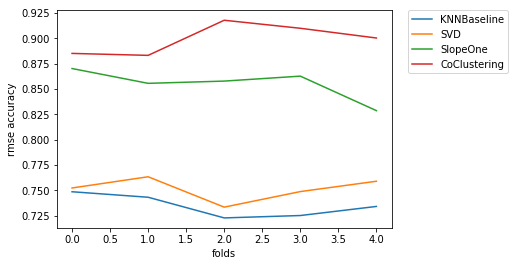

In [43]:
#plotting the prediction data:
import matplotlib.pyplot as plt
for prediction in range(0,1):
    modelPrediction = plt.plot(rmseKNN,label='KNNBaseline')
    modelPrediction = plt.plot(rmseSVD,label='SVD')
    modelPrediction = plt.plot(rmseSlopeOne,label='SlopeOne')
    modelPrediction = plt.plot(rmseCC,label='CoClustering')

    modelPrediction = plt.xlabel('folds')
    modelPrediction = plt.ylabel('rmse accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<h2>Nos quedamos con los algoritmos KNN</h2>

<p>Vamos a analizar cuál de las cuatro variantes que nos ofrece Surprise es la que mejores resultados da.</p>

In [44]:
# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings

<h3>KNNBasic</h3>

In [45]:
from surprise import KNNBasic

param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3, 5, 10, 20, 40, 50],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

# param_grid = {
#               'k': [40],
#                 'sim_options': {'name': ['msd', 'pearson_baseline', 'cosine'],
#                               'user_based': [False]}
#               }

gsKNNBasic = GridSearchCV(KNNBasic, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsKNNBasic.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  5.4min finished


In [46]:
# best RMSE score
print(gsKNNBasic.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsKNNBasic.best_params['rmse'])

0.844103090595004
{'bsl_options': {'method': 'sgd', 'reg': 2}, 'k': 5, 'sim_options': {'name': 'pearson_baseline', 'min_support': 1, 'user_based': False}}


In [47]:
algoBasic = gsKNNBasic.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algoBasic.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algoBasic.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Unbiased accuracy on unbiased testData, RMSE: 0.8407


In [48]:
rmseKNNBasic = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algoBasic.fit(trainset)
    predictions = algoBasic.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseKNNBasic.append(acc)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8520
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8434
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8461
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8327
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8455


<h3>KNNWithMeans</h3>

In [49]:
# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings

In [50]:
from surprise import KNNWithMeans

param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3, 5, 10, 20, 40, 50],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

# param_grid = {
#               'k': [40],
#                 'sim_options': {'name': ['msd', 'pearson_baseline', 'cosine'],
#                               'user_based': [False]}
#               }

gsKNNWithMeans = GridSearchCV(KNNWithMeans, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsKNNWithMeans.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  5.1min finished


In [51]:
# best RMSE score
print(gsKNNWithMeans.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsKNNWithMeans.best_params['rmse'])

0.891309513697348
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 3, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': False}}


In [52]:
algoWithMeans = gsKNNWithMeans.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algoWithMeans.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algoWithMeans.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Unbiased accuracy on unbiased testData, RMSE: 0.8863


In [53]:
rmseKNNWithMeans = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algoWithMeans.fit(trainset)
    predictions = algoWithMeans.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseKNNWithMeans.append(acc)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8689
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8919
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9050
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9156
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8899


<h3>KNNWithZScore</h3>

In [55]:
# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings

In [56]:
from surprise import KNNWithZScore

param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3, 5, 10, 20, 40, 50],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

# param_grid = {
#               'k': [40],
#                 'sim_options': {'name': ['msd', 'pearson_baseline', 'cosine'],
#                               'user_based': [False]}
#               }

gsKNNWithZScore = GridSearchCV(KNNWithZScore, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsKNNWithZScore.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  5.3min finished


In [57]:
# best RMSE score
print(gsKNNWithZScore.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsKNNWithZScore.best_params['rmse'])

0.8871742381607135
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 3, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': False}}


In [58]:
algoKNNWithZScore = gsKNNWithZScore.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algoKNNWithZScore.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algoKNNWithZScore.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Unbiased accuracy on unbiased testData, RMSE: 0.8891


In [59]:
rmseKNNWithZScore = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algoKNNWithZScore.fit(trainset)
    predictions = algoKNNWithZScore.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseKNNWithZScore.append(acc)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8839
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8860
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8938
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8871
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9043


<h3>KNNBaseline</h3>

In [92]:
# data ahora tendrá los datos de training
data.raw_ratings = train_raw_ratings

In [93]:
from surprise import KNNBaseline

param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3, 5, 10, 20, 40, 50],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

# param_grid = {
#               'k': [40],
#                 'sim_options': {'name': ['msd', 'pearson_baseline', 'cosine'],
#                               'user_based': [False]}
#               }

gsKNNBaseline = GridSearchCV(KNNBaseline, 
                     param_grid, 
                     measures=['rmse'], 
                     cv=5,
                     n_jobs=-1,
                     joblib_verbose = 2)

gsKNNBaseline.fit(data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    6.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.9s finished


In [94]:
# best RMSE score
print(gsKNNBaseline.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gsKNNBaseline.best_params['rmse'])

0.7363008926610746
{'k': 40, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}


In [95]:
algoKNNBaseline = gsKNNBaseline.best_estimator['rmse']
trainset = data.construct_trainset(train_raw_ratings)
algoKNNBaseline.fit(trainset)

# Predecimos los ratings sobre los datos de test
testset = data.construct_testset(test_raw_ratings)
predictions = algoKNNBaseline.test(testset)

print('Unbiased accuracy on unbiased testData,', end=' ')
acc = accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Unbiased accuracy on unbiased testData, RMSE: 0.7352


In [96]:
rmseKNNBaseline = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algoKNNBaseline.fit(trainset)
    predictions = algoKNNBaseline.test(testset)

    # Compute and print Root Mean Squared Error
    acc = accuracy.rmse(predictions, verbose=True)
    
    rmseKNNBaseline.append(acc)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7229
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7515
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7271
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7405
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7333


<h3>Graficamos los errores de las diferentes variantes del algoritmo KNN</h3>

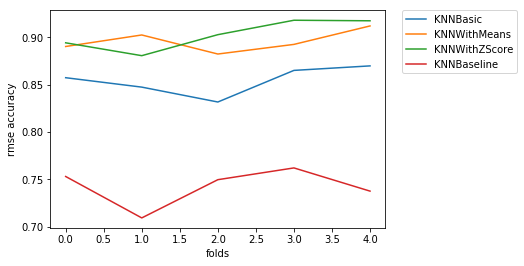

In [65]:
#plotting the prediction data:
import matplotlib.pyplot as plt
for prediction in range(0,1):
    modelPrediction = plt.plot(rmseKNNBasic,label='KNNBasic')
    modelPrediction = plt.plot(rmseKNNWithMeans,label='KNNWithMeans')
    modelPrediction = plt.plot(rmseKNNWithZScore,label='KNNWithZScore')
    modelPrediction = plt.plot(rmseKNNBaseline,label='KNNBaseline')

    modelPrediction = plt.xlabel('folds')
    modelPrediction = plt.ylabel('rmse accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [117]:
bestAlgo = algoKNNBaseline

<h2>Finalmente, obtenemos las recomendaciones.</h2>

In [118]:
def read_item_names():
    """Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    """

    file_name = os.path.expanduser('../TFM Files/CLB2/idTitleList.csv')
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split(',')
            master_id = line[0]
            title = line[1].rstrip('\n')
            rid_to_name[master_id] = title
            name_to_rid[title] = master_id

    return rid_to_name, name_to_rid

In [119]:
# Read the mappings raw id <-> movie name
rid_to_name, name_to_rid = read_item_names()

In [120]:
# Utilizamos el release con más votaciones para tener mejores recomendaciones
release_raw_id = name_to_rid['Per Un Amico']
release_inner_id = bestAlgo.trainset.to_inner_iid(release_raw_id)

In [121]:
release_inner_id

1132

In [122]:
# Retrieve inner ids of the nearest neighbors of the release.
release_neighbors = bestAlgo.get_neighbors(release_inner_id, k=10)

In [123]:
release_neighbors

[1574, 1313, 13, 374, 600, 946, 1853, 3758, 4259, 4290]

In [124]:
# Convert inner ids of the neighbors into names.
release_neighbors = (bestAlgo.trainset.to_raw_iid(inner_id)
                       for inner_id in release_neighbors)
release_neighbors = (rid_to_name[rid]
                       for rid in release_neighbors)

In [125]:
print('Las 10 recomendaciones para Per Un Amigo:')
for title in release_neighbors:
    print(title)

Las 10 recomendaciones para Per Un Amigo:
Cameosis
Even If You Don't
Die Barke Mit Der GlÃÂ¤sernen Fracht
( )
QuotÃÂ¤reglÃÂ¤r
Tunnel Trance Force Vol.57
Get On Up
Adagio Furioso
Instinctual
Eternal (New Remix Edition)
